In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Circle, Rectangle, Ellipse

from sklearn.preprocessing import MinMaxScaler

#Regressoors
from sklearn.neural_network import MLPRegressor
from sklearn.cross_decomposition.pls_ import PLSRegression
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge , Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, AdaBoostRegressor 
from xgboost import XGBRegressor

#PCA
from sklearn.decomposition import RandomizedPCA, PCA
#MDS
from sklearn.manifold import MDS
#SNE
from sklearn.manifold import TSNE

#Train Test Split
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import statsmodels.api as sm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import interact, interact_manual

/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Загрузим спектр лампы

In [3]:
df = pd.read_csv('Lampa_10.24ms.txt', sep=' ')
Lamp_Spectrum = df.iloc[:1024,4:5].T
Lamp_Spectrum.iloc[0,:] = map(lambda x: float(x), Lamp_Spectrum.iloc[0,:].values)

In [4]:
scaler = MinMaxScaler()
#for i in range(lowess_df.shape[0]):
scaler.fit(Lamp_Spectrum.T)
Lamp_Spectrum = pd.DataFrame(scaler.transform(Lamp_Spectrum.T)).T

## Вариант 2

Объединим все серии измеренных спектров (18,19,20 .03), в полученном датасете сгладим шумы, отмасштабируем на (0,1) MinMaxScale, и спроецируем в пространство PCA

Тестовый датасет так же подготовим, и спроецируем на главные компоненты обучающей выбоорки

In [1]:
# Калибровка из номера канала в нм
chnl_to_nm = np.linspace(443.86,1007.41, 1024)

# Загружаем
Data_Dry = pd.read_csv('prep_data_20190318.csv', sep=',')
Data_SemiSweet = pd.read_csv('prep_data_20190319.csv', sep=',')
Data_SemiDry = pd.read_csv('prep_data_20190320.csv', sep=',')

Data_Dry.drop('Unnamed: 0', axis=1, inplace=True)
Data_SemiSweet.drop('Unnamed: 0', axis=1, inplace=True)
Data_SemiDry.drop('Unnamed: 0', axis=1, inplace=True)

NameError: name 'np' is not defined

In [6]:
# Объединяем
Data = pd.concat([Data_Dry, Data_SemiDry, Data_SemiSweet], axis=0)

In [7]:
# Сортируем по pH
Data.sort_values('pH', inplace=True)

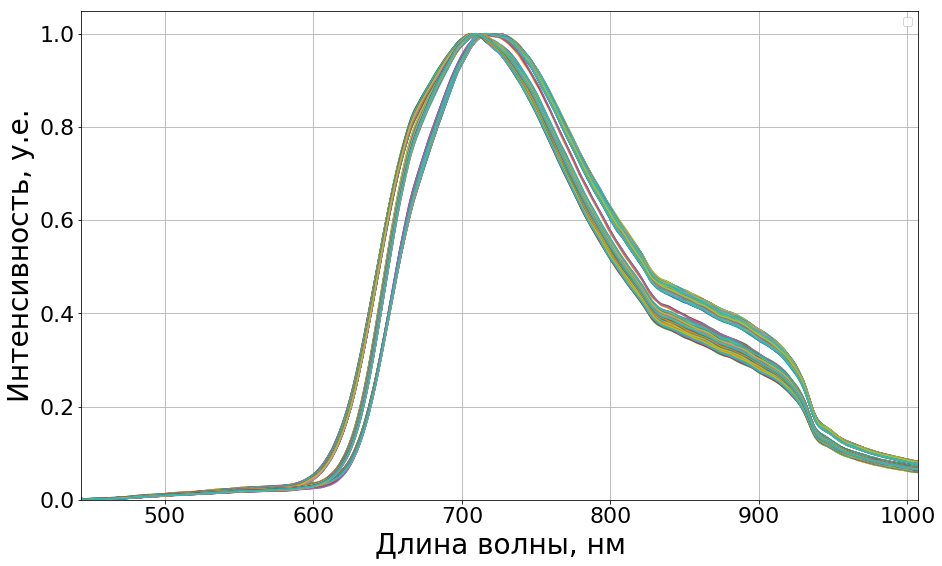

In [8]:
plt.figure(figsize=(15,9))
#plt.yscale('symlog')
plt.grid(which=u'both')
for i in range(Data.shape[0]):
    plt.plot(chnl_to_nm , Data.iloc[i,:-1].values)
#plt.plot(chnl_to_nm, Lamp_Spectrum.iloc[0,:].values*100, c='b', label=u'Спектр лампы накаливания' )
plt.xlim(chnl_to_nm[0], chnl_to_nm[-1])
plt.ylim(0)
plt.xlabel(u'Длина волны, нм', fontsize=28)
plt.ylabel(u'Интенсивность, у.е.', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=12)
plt.savefig('ph_reg_scaled_spectra.pdf')

plt.show()

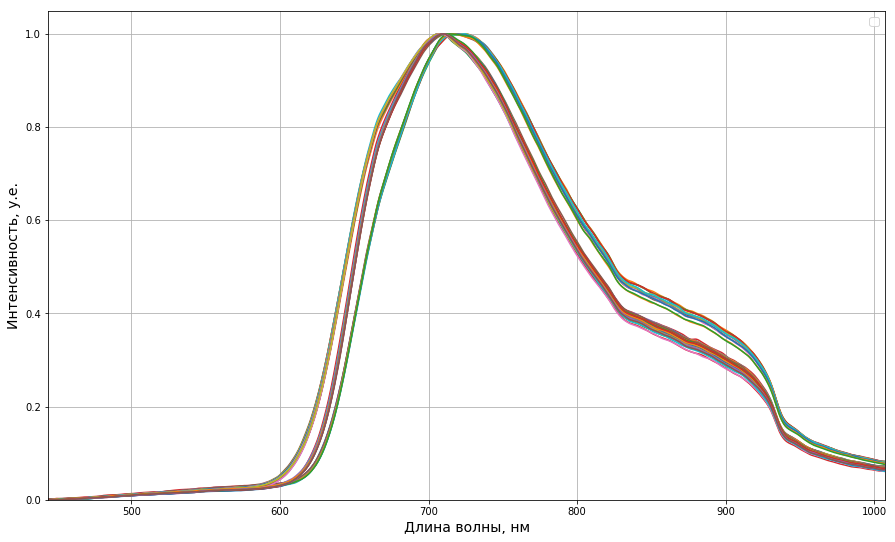

In [28]:
plt.figure(figsize=(15,9))
plt.grid(which=u'both')
for i in range(Data.shape[0]):
    if i%10==0:
        plt.plot(chnl_to_nm , Data.iloc[i,:-1].values)
plt.xlim(chnl_to_nm[0], chnl_to_nm[-1])
plt.ylim(0)
plt.xlabel(u'Длина волны, нм', fontsize=14)
plt.ylabel(u'Интенсивность, у.е.', fontsize=14)
plt.legend(fontsize=12)
plt.show()

TypeError: set_ticklabels() got an unexpected keyword argument 'size'

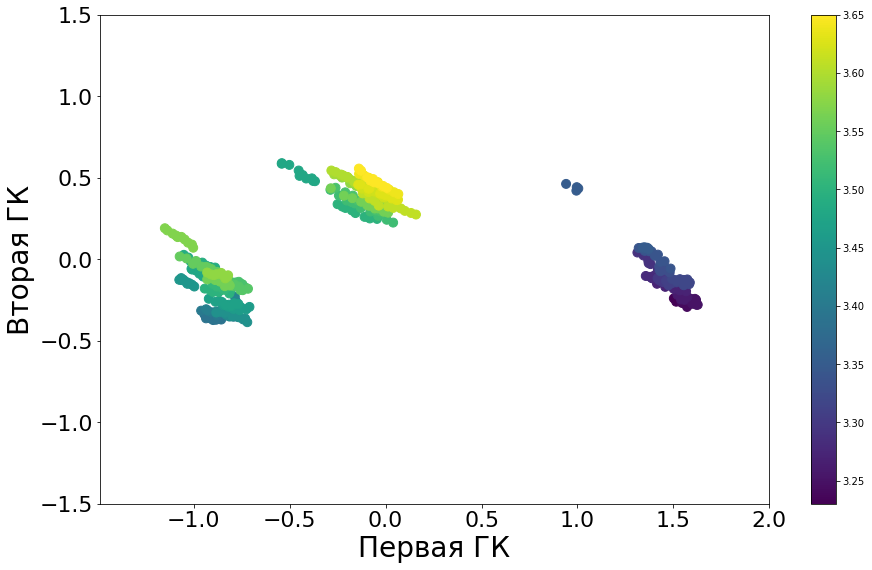

In [53]:
pca_model = PCA(n_components=3)
pca_model.fit(Data.drop('pH', axis=1))
PCA_Data = pd.DataFrame(pca_model.transform(Data.drop('pH', axis=1)))
PCA_Data['pH'] = Data.pH.values

plt.figure(figsize=(15,9))
plt.scatter(PCA_Data.iloc[:,0], PCA_Data.iloc[:,1], c=PCA_Data.pH.values[:], s=80)


#plt.title(u'Проекции спектров из обучающей выборки на ГК', fontsize=25)
plt.xlabel(u'Первая ГК', fontsize=28)
plt.ylabel(u'Вторая ГК', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.xlim(-1.49,2)
plt.ylim(-1.5,1.5)

# plt.gca().add_patch(Circle((-0.20,0.4),0.4,linewidth=3,edgecolor='lightblue',facecolor='none'))
# plt.text(0.1,0,u'"Лази", Сухое', fontsize=16)

# plt.gca().add_patch(Circle((-0.90,-0.1),0.35,linewidth=3,edgecolor='lightgreen',facecolor='none'))
# plt.text(-0.7,-0.5,u'"Пиросмани", Полусухое', fontsize=16)

# plt.gca().add_patch(Ellipse((1.3,0), 0.45, 1.6, angle=45, linewidth=3,edgecolor='pink',facecolor='none'))
# plt.text(0.85,0.65,u'"Tamagne", Полусладкое', fontsize=16)

cb = plt.colorbar()
cb.set_ticklabels(size=15)
plt.grid()
plt.savefig('ph_reg_pca_plot_train.pdf')


In [30]:
# Доля объясненной диперсии PCA :
for i, ratio in enumerate(pca_model.explained_variance_ratio_):
    print u'Доля дисперсии ', i, '-й компоненты : ', ratio.round(4)*100, '%'
print pca_model.explained_variance_ratio_.sum().round(4)*100,'%'

Доля дисперсии  0 -й компоненты :  91.93 %
Доля дисперсии  1 -й компоненты :  7.75 %
Доля дисперсии  2 -й компоненты :  0.19 %
99.86 %


In [31]:
PCA_Data.to_csv('quick_plot.csv', sep=',')

Mean Squared Error :  0.0166


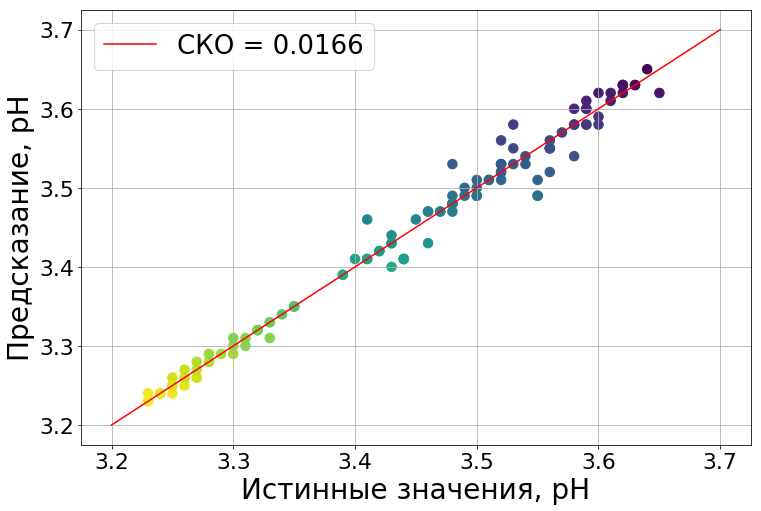

In [36]:
train_data, test_data, train_target, test_target = train_test_split(PCA_Data.drop('pH', axis=1),
                                                                    PCA_Data.pH,
                                                                   test_size=0.25, random_state=123)

#LinearRegression() 
#XGBRegressor(max_depth=8, n_estimators=70)
#GradientBoostingRegressor(learning_rate=0.08, n_estimators=200, max_depth=7)

regressor = GradientBoostingRegressor(learning_rate=0.08, n_estimators=200, max_depth=7)
regressor.fit(train_data, train_target)
preds = regressor.predict(test_data)
 
#print 'Test Data : ', test_target.values
#print 'Predictions : ', preds.round(2)
#print 'Delta : ', test_target.values - preds.round(2)
print 'Mean Squared Error : ', np.sqrt(MSE(test_target.values, preds)).round(4)

plt.figure(figsize=(12,8))
plt.plot(np.arange(3.2,3.8,0.1), np.arange(3.2,3.8,0.1), c='r', label=u'СКО = '+str(np.sqrt(MSE(test_target.values, preds)).round(4)))
plt.scatter(test_target.values, preds.round(2),  c=1-(preds-preds.min())/preds.max(), s=90)
plt.xlabel(u'Истинные значения, pH', fontsize=28)
plt.ylabel(u'Предсказание, pH', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.title(u'Качество регрессии', fontsize=30)
plt.legend(fontsize=26)
plt.grid()
plt.savefig('ph_reg_train_res.pdf')

In [14]:
regressors = []
mse_array = []
scores = []
for i in range(100):
    train_data, test_data, train_target, test_target = train_test_split(PCA_Data.drop('pH', axis=1),
                                                                        PCA_Data.pH,
                                                                        test_size=0.25, random_state=i)

    
    #LinearRegression() 
    #GradientBoostingRegressor(learning_rate=0.08, n_estimators=200, max_depth=7)
        
    regressor = GradientBoostingRegressor(loss='lad', learning_rate=0.08, n_estimators=200,
                                          max_depth=7, random_state=i, criterion='mse', subsample=0.75)
    regressor.fit(train_data, train_target)
    preds = regressor.predict(test_data)
    
    regressors.append(regressor)
    mse_array.append(MSE(test_target.values, preds.round(2)))
    scores.append(regressor.score(test_data, test_target))
    
print 'MSE : ', mse_array[:20]
print 
print 'Corrs : ', scores[:20]
print 
print 'Среднее MSE по 100 случайным выборкам : ', np.sqrt(np.mean(mse_array)).round(4)
print 'Средняя корреляция по 100 случайным выборкам : ', np.mean(scores).round(4)

MSE :  [0.00029304347826086916, 0.00020782608695652148, 0.00020086956521739145, 0.0002052173913043472, 0.00024173913043478172, 0.0003086956521739132, 0.00027043478260869514, 0.0002234782608695645, 0.00030782608695652084, 0.00026347826086956444, 0.00028173913043478155, 0.0002904347826086953, 0.0001869565217391303, 0.00026347826086956563, 0.0002939130434782609, 0.0002930434782608692, 0.00017043478260869534, 0.00022521739130434838, 0.00026086956521739106, 0.0003617391304347809]

Corrs :  [0.9816779762388225, 0.985904464543623, 0.9867482617457811, 0.9849311455564094, 0.9860202863979237, 0.9791491935693826, 0.9809199995525227, 0.9862231152084174, 0.9801814550773918, 0.9852772555380357, 0.9792667115751156, 0.978556655092004, 0.9886694326204917, 0.9832802747121281, 0.9813701697424093, 0.9828170249929183, 0.9880781769331547, 0.9861138767204797, 0.9840427297902533, 0.9771358083636835]

Среднее MSE по 100 случайным выборкам :  0.0155
Средняя корреляция по 100 случайным выборкам :  0.9843


## Загрузим тестовые данные

In [15]:
Testing_Data = pd.read_csv('Test_for_model_21_03.txt', sep=' ')
Testing_Data.drop(['Channel', 'Wavelength(nm)', 'Current', 'BackGround', 'Unnamed: 44'], axis=1, inplace=True)
Testing_Data = Testing_Data.iloc[:1024,:].T
Testing_Data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
Spectrum1,20,35,25,22,27,14,31,20,16,30,...,1101,1102,1071,1077,1088,1103,1063,1058,1086,1056
Spectrum2,0,26,22,16,18,12,26,29,-13,22,...,1066,1068,1064,1065,1039,1078,1057,1068,1018,1012
Spectrum3,7,5,19,-11,15,7,40,27,50,26,...,1028,1041,1026,1033,1051,1026,1031,1014,1046,985
Spectrum4,41,30,25,11,27,5,30,9,38,30,...,1019,1032,1014,1026,1003,1004,990,993,1005,1009
Spectrum5,-3,30,6,48,42,29,22,30,12,15,...,992,993,986,996,994,997,987,982,1005,977
Spectrum6,15,5,28,26,17,25,-10,30,9,42,...,999,957,971,975,1000,993,950,957,960,971
Spectrum7,28,0,3,20,36,18,19,19,27,66,...,982,932,959,986,937,972,942,937,961,932
Spectrum8,13,31,19,-2,0,-3,12,15,45,8,...,942,947,941,963,970,961,905,948,917,907
Spectrum9,5,-4,21,16,28,-7,-7,24,24,37,...,947,948,939,939,955,938,891,892,920,917
Spectrum10,31,13,39,30,15,-10,47,38,30,37,...,1044,1063,1027,1028,1056,1047,1011,1031,1019,999


In [16]:
# Первая строка датафрейма почему то состоит из строк -- исправим
Testing_Data.iloc[0,:] = map(lambda x: float(x), Testing_Data.iloc[0,:].values)

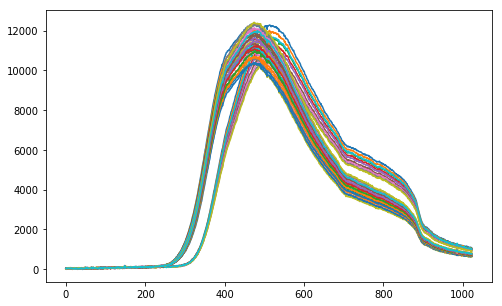

In [17]:
plt.figure(figsize=(8,5))
for i in range(40):
    plt.plot(range(1024) ,Testing_Data.iloc[i,:].values)

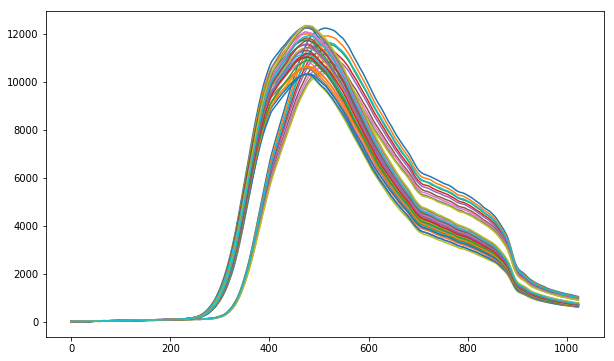

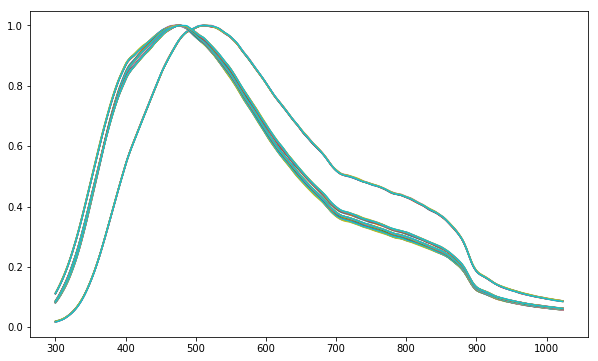

In [18]:
data_lowess_1 = list()
plt.figure(figsize=(10,6))
for i in range(Testing_Data.shape[0]) :
    x = range(Testing_Data.shape[1])
    y = Testing_Data.iloc[i,:].values
    lowess = sm.nonparametric.lowess(y, x, frac=0.015)
    plt.plot(lowess[:,0], lowess[:,1])
    data_lowess_1.append(lowess[:,1])

lowess_Testing_Data = pd.DataFrame(np.array(data_lowess_1))

scaler = MinMaxScaler()
#for i in range(lowess_df.shape[0]):
scaler.fit(lowess_Testing_Data.T)
lowess_Testing_Data = pd.DataFrame(scaler.transform(lowess_Testing_Data.T)).T

plt.figure(figsize=(10,6))
for i in range(40):
    plt.plot(range(300,1024) ,lowess_Testing_Data.iloc[i,300:].values)

In [19]:
pH = np.array([3.38]*10+[3.21]*10+[3.75]*10+[3.58]*10)
lowess_Testing_Data['pH'] = pH

## Посмотрим куда ложатся точки Тестовой выборки на отмасштабированной плоскости двух главных компонент

In [20]:
@interact
def plot_pca(i=(0,3,1)):
    PCA_Testing_Data = pd.DataFrame(pca_model.transform(lowess_Testing_Data.drop('pH', axis=1)))
    PCA_Testing_Data['pH'] = lowess_Testing_Data.pH.values


    plt.figure(figsize=(15,12))

    plt.subplot(2,2,1)
    plt.scatter(PCA_Data.iloc[:,0], PCA_Data.iloc[:,1], c=PCA_Data.pH.values[:], s=80)
    plt.scatter(PCA_Testing_Data.iloc[i*10:i*10+10,0], PCA_Testing_Data.iloc[i*10:i*10+10,1], c='r', s=80)
    plt.grid()

    plt.subplot(2,2,2)
    plt.scatter(PCA_Data.iloc[:,0], PCA_Data.iloc[:,1], c=PCA_Data.pH.values[:], s=80)
    plt.scatter(PCA_Testing_Data.iloc[i*10:i*10+10,0], PCA_Testing_Data.iloc[i*10:i*10+10,1], c=PCA_Testing_Data.pH.values[i*10:i*10+10], s=80)
    plt.grid()

    plt.colorbar()
    plt.show()

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFNsaWRlcih2YWx1ZT0xLCBkZXNjcmlwdGlvbj11J2knLCBtYXg9MyksIE91dHB1dCgpKSwgX2RvbV9jbGFzc2VzPSh1J3dpZGdldC1pbnRlcmFjdCfigKY=


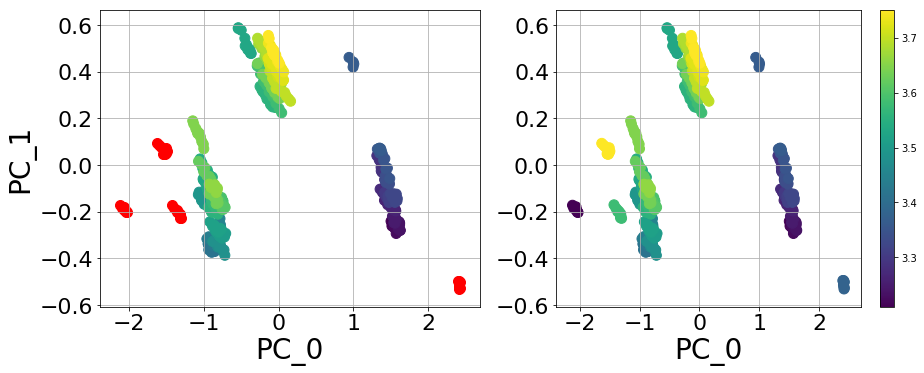

In [21]:
PCA_Testing_Data = pd.DataFrame(pca_model.transform(lowess_Testing_Data.drop('pH', axis=1)))
PCA_Testing_Data['pH'] = lowess_Testing_Data.pH.values


plt.figure(figsize=(15,12))

plt.subplot(2,2,1)
plt.scatter(PCA_Data.iloc[:,0], PCA_Data.iloc[:,1], c=PCA_Data.pH.values[:], s=100)
plt.scatter(PCA_Testing_Data.iloc[:,0], PCA_Testing_Data.iloc[:,1], c='r', s=100)

plt.xlabel('PC_0', fontsize=28)
plt.ylabel('PC_1', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.grid()

plt.subplot(2,2,2)
plt.scatter(PCA_Data.iloc[:,0], PCA_Data.iloc[:,1], c=PCA_Data.pH.values[:], s=100)
plt.scatter(PCA_Testing_Data.iloc[:,0], PCA_Testing_Data.iloc[:,1], c=PCA_Testing_Data.pH.values[:], s=100)
#plt.gca().add_patch(Circle((-2.06,-0.19),0.13,linewidth=2,edgecolor='r',facecolor='none'))
#plt.text(-2.2,-0.45,u'№1', fontsize=25)
plt.grid()


#plt.title(u'Проекции спектров из обучающей выборки на ГК', fontsize=26)
plt.xlabel('PC_0', fontsize=28)
#plt.ylabel('PC_1', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.colorbar()

plt.savefig('ph_reg_pca_plot_test.pdf')

plt.show()

In [22]:
Predictions = []
for reg in regressors:
    Predictions.append(reg.predict(PCA_Testing_Data.drop('pH', axis=1)))
Predictions = np.array(Predictions)

In [23]:
Prediction = Predictions.mean(axis=0)

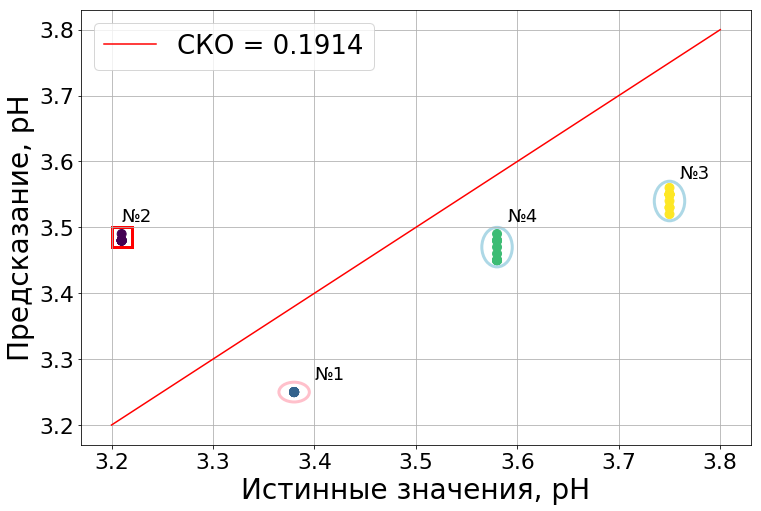

MSE :  0.1914


In [35]:
plt.figure(figsize=(12,8))

plt.plot(np.arange(3.2,3.9,0.1), np.arange(3.2,3.9,0.1), c='r', label=u'СКО = '+str(np.sqrt(MSE(Prediction, PCA_Testing_Data.pH.values)).round(4)))
#plt.plot(np.arange(3.2,3.8,0.1), np.arange(3.2,3.8,0.1)+0.18, c='orange', linestyle='dashed')

plt.scatter(PCA_Testing_Data.pH.values, Prediction.round(2), c=PCA_Testing_Data.pH.values, s=80)
plt.xlabel(u'Истинные значения, pH',  fontsize=28)
plt.ylabel(u'Предсказание, pH', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.title(u'Качество регрессии', fontsize=30)


plt.gca().add_patch(Rectangle((3.2,3.47),0.02,0.03,linewidth=3,edgecolor='r',facecolor='none'))
plt.text(3.21,3.51,u'№2', fontsize=18) #Таманский погреб

plt.gca().add_patch(Circle((3.38,3.25),0.015,linewidth=3,edgecolor='pink',facecolor='none'))
plt.text(3.40,3.27,u'№1', fontsize=18) #Tamai, "Cabernet"

plt.gca().add_patch(Ellipse((3.58,3.47),0.03,0.06,linewidth=3,edgecolor='lightblue',facecolor='none'))
plt.text(3.59,3.51,u'№4', fontsize=18) #"Carbieres"

plt.gca().add_patch(Ellipse((3.75,3.54),0.03,0.06,linewidth=3,edgecolor='lightblue',facecolor='none'))
plt.text(3.76,3.575,u'№3', fontsize=18) #"Саперави"


plt.legend(fontsize=26)
plt.grid()
plt.savefig('ph_reg_test_res.pdf')

plt.show()
print 'MSE : ', np.sqrt(MSE(Prediction, PCA_Testing_Data.pH.values)).round(4)

In [34]:
r2_score(PCA_Testing_Data.pH.values, Prediction,).round(3)

0.116

In [67]:
def approx_line(X, Y):
    # Посчитаем все необходимые суммы
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_x2 = np.sum(X*X)
    sum_xy = np.sum(X*Y)
    
    # Матрица А
    A = np.array([[sum_x2, sum_x],[sum_x, 1.0]])
    # Свободный вектор b
    b = np.array([sum_xy, sum_y])
    # Коэффициенты a,b
    coeffs = np.linalg.solve(A, b)
    
    return coeffs

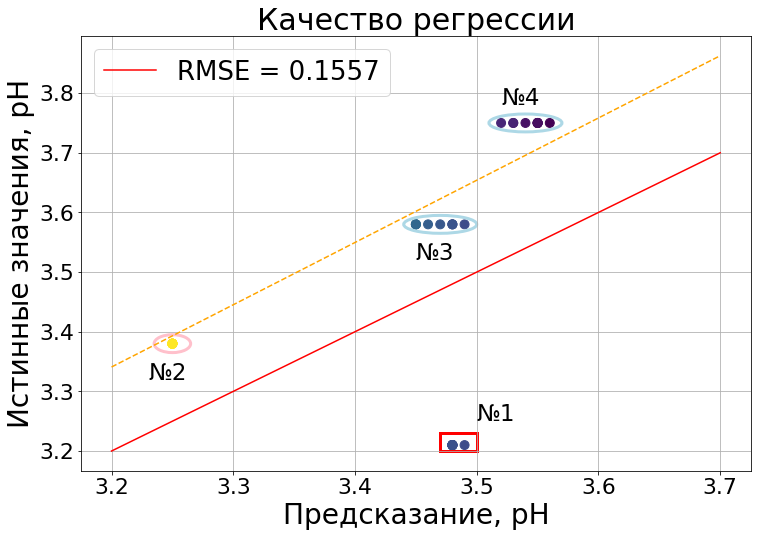

MSE :  0.1557
1.04 0.00064


In [124]:
Preds_without_TP = np.concatenate((Prediction[:10], Prediction[20:]))
PCA_Testing_Data_without_TP = PCA_Testing_Data.pH[PCA_Testing_Data.pH != 3.21].values

a, b = approx_line(Preds_without_TP, PCA_Testing_Data_without_TP)

plt.figure(figsize=(12,8))

plt.plot(np.arange(3.2,3.8,0.1), np.arange(3.2,3.8,0.1), c='r', label='RMSE = '+str(np.sqrt(MSE(Preds_without_TP, PCA_Testing_Data_without_TP)).round(4)))
plt.plot(np.arange(3.2,3.8,0.1), a*np.arange(3.2,3.8,0.1)+b, c='orange', linestyle='dashed')
plt.scatter(Prediction.round(2), PCA_Testing_Data.pH.values,
            c=1-(Prediction-Prediction.min())/Prediction.max(), s=80)

plt.xlabel(u'Предсказание, pH', fontsize=28)
plt.ylabel(u'Истинные значения, pH', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title(u'Качество регрессии', fontsize=30)


plt.gca().add_patch(Rectangle((3.47,3.2),0.03,0.03,linewidth=3,edgecolor='r',facecolor='none'))
plt.text(3.5,3.25,u'№1', fontsize=23) #Таманский погреб

plt.gca().add_patch(Circle((3.25,3.38),0.015,linewidth=3,edgecolor='pink',facecolor='none'))
plt.text(3.23,3.32,u'№2', fontsize=23) #Tamai, "Cabernet"

plt.gca().add_patch(Ellipse((3.47,3.58),0.06,0.03,linewidth=3,edgecolor='lightblue',facecolor='none'))
plt.text(3.45,3.52,u'№3', fontsize=23) #"Carbieres"

plt.gca().add_patch(Ellipse((3.54,3.75),0.06,0.03,linewidth=3,edgecolor='lightblue',facecolor='none'))
plt.text(3.52,3.78,u'№4', fontsize=23) #"Саперави"
plt.legend(fontsize=26)
plt.grid()
plt.show()
print 'MSE : ', np.sqrt(MSE(Preds_without_TP, PCA_Testing_Data_without_TP)).round(4)
print a.round(2), b.round(5)

In [94]:
np.concatenate((Prediction[:10], Prediction[20:]))

array([3.25050511, 3.25032592, 3.25029846, 3.25012311, 3.25050053,
       3.25057001, 3.24983298, 3.25066347, 3.24970895, 3.25023501,
       3.55638009, 3.55478868, 3.55179688, 3.53246131, 3.54693085,
       3.54318914, 3.55238568, 3.54553845, 3.52711994, 3.52342941,
       3.48590935, 3.48475028, 3.48012199, 3.47666658, 3.46494399,
       3.45179355, 3.44861611, 3.47283027, 3.44759635, 3.45379235])

In [101]:
PCA_Testing_Data.pH[PCA_Testing_Data.pH != 3.21].values

array([3.38, 3.38, 3.38, 3.38, 3.38, 3.38, 3.38, 3.38, 3.38, 3.38, 3.75,
       3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.75, 3.58, 3.58,
       3.58, 3.58, 3.58, 3.58, 3.58, 3.58, 3.58, 3.58])

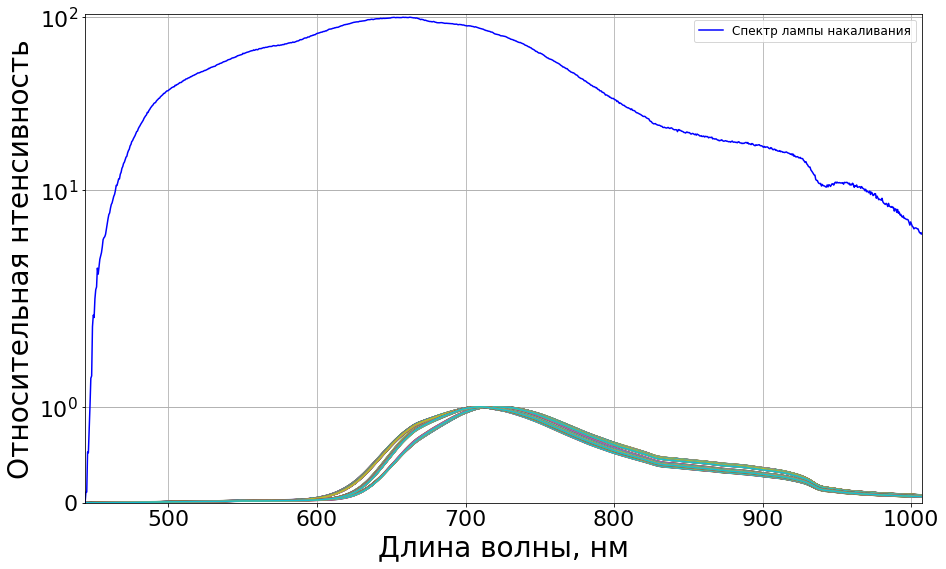

In [128]:
plt.figure(figsize=(15,9))
#plt.yscale('symlog')
plt.grid(which=u'both')
for i in range(Data.shape[0]):
    plt.plot(chnl_to_nm , Data.iloc[i,:-1].values)
plt.plot(chnl_to_nm, Lamp_Spectrum.iloc[0,:].values*100, c='b', label=u'Спектр лампы накаливания' )
plt.xlim(chnl_to_nm[0], chnl_to_nm[-1])
plt.ylim(0)
plt.xlabel(u'Длина волны, нм', fontsize=28)
plt.ylabel(u'Относительная нтенсивность', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.yscale(u'symlog')
plt.legend(fontsize=12)
plt.show()

In [149]:
Opt_Dens_DF = pd.DataFrame( np.log10(Lamp_Spectrum.values / Data.drop('pH', axis=1).values) )

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in divide
  """Entry point for launching an IPython kernel.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in divide
  """Entry point for launching an IPython kernel.
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [150]:
Opt_Dens_DF.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,NaN,1.275551,0.987091,1.512922,1.415846,1.502940,1.526822,1.463625,1.331177,1.453319,...,-0.136056,-0.132304,-0.132677,-0.135717,-0.136279,-0.148781,-0.159220,-0.158738,-0.167598,-0.159776
1,-inf,1.794305,2.853459,inf,2.723975,2.466766,2.280142,1.964098,1.543150,1.434452,...,-0.134343,-0.131212,-0.131468,-0.133190,-0.132314,-0.143372,-0.152313,-0.150243,-0.157411,-0.147786
2,-inf,1.326905,1.263086,1.968191,2.043722,2.287612,2.450643,inf,3.396076,2.364364,...,-0.130323,-0.126426,-0.126095,-0.127593,-0.126429,-0.137146,-0.145805,-0.143576,-0.150735,-0.141243
3,-inf,0.227741,0.315824,1.101428,1.252210,1.668623,2.311818,inf,2.614557,2.407625,...,-0.133795,-0.129532,-0.128540,-0.129278,-0.127436,-0.137481,-0.145404,-0.142368,-0.148654,-0.138238
4,NaN,1.172954,0.879603,1.392086,1.273029,1.341544,1.360658,1.329467,1.234040,1.307131,...,-0.138873,-0.134758,-0.133832,-0.134481,-0.132553,-0.142485,-0.150254,-0.147024,-0.153093,-0.142464


In [151]:
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,pH
459,0.000000,0.000059,0.000116,0.000162,0.000200,0.000239,0.000302,0.000446,0.000617,0.000646,...,0.081907,0.081651,0.081568,0.081564,0.081577,0.081596,0.081621,0.081654,0.081701,3.23
457,0.000050,0.000018,0.000002,0.000000,0.000010,0.000026,0.000053,0.000141,0.000378,0.000675,...,0.081701,0.081424,0.081095,0.080823,0.080567,0.080309,0.080040,0.079761,0.079476,3.23
456,0.000029,0.000053,0.000061,0.000057,0.000047,0.000039,0.000036,0.000000,0.000005,0.000079,...,0.080806,0.080423,0.080056,0.079735,0.079420,0.079114,0.078821,0.078544,0.078288,3.23
455,0.000790,0.000664,0.000542,0.000419,0.000291,0.000163,0.000050,0.000000,0.000032,0.000072,...,0.081386,0.080877,0.080368,0.079920,0.079481,0.079042,0.078602,0.078169,0.077748,3.23
454,0.000000,0.000075,0.000148,0.000214,0.000278,0.000347,0.000443,0.000608,0.000771,0.000904,...,0.082371,0.081869,0.081336,0.080867,0.080403,0.079929,0.079449,0.078972,0.078508,3.23


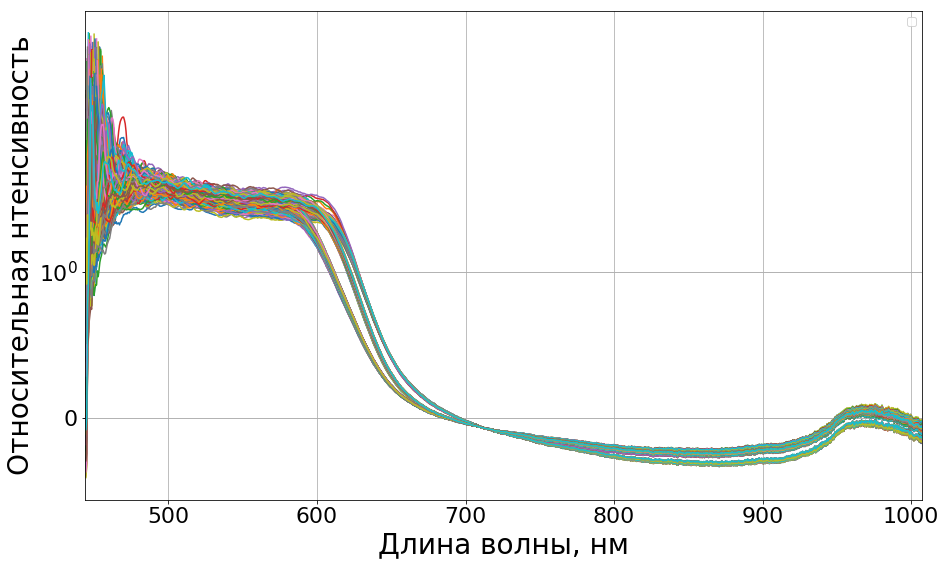

In [154]:
plt.figure(figsize=(15,9))
plt.yscale('symlog')
plt.grid(which=u'both')
for i in range(Opt_Dens_DF.shape[0]):
    plt.plot(chnl_to_nm , Opt_Dens_DF.iloc[i,:].values)

plt.xlim(chnl_to_nm[0], chnl_to_nm[-1])
#plt.ylim(0)
plt.xlabel(u'Длина волны, нм', fontsize=28)
plt.ylabel(u'Относительная нтенсивность', fontsize=28)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.yscale(u'symlog')
plt.legend(fontsize=12)
plt.show()

# Попробуем 2-ую производную : $\frac{\partial I}{\partial \lambda}$

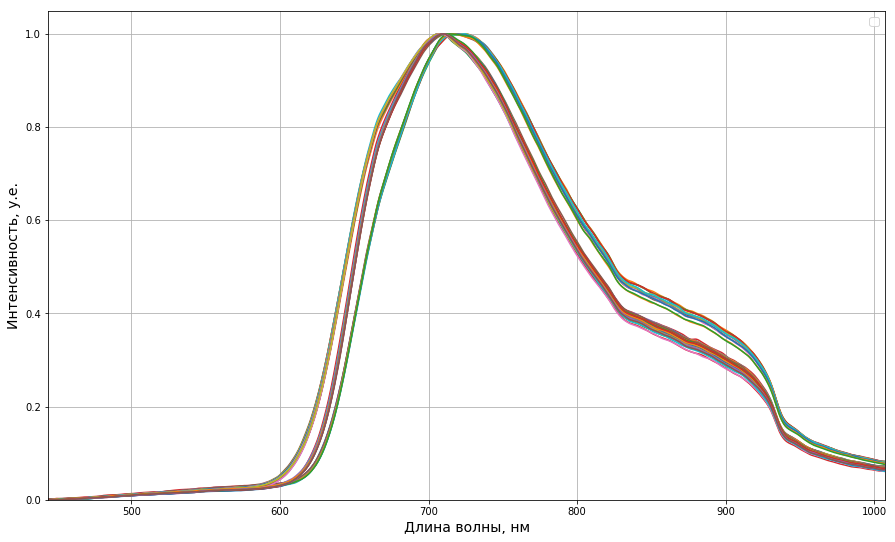

In [10]:
plt.figure(figsize=(15,9))
plt.grid(which=u'both')
for i in range(Data.shape[0]):
    if i%10==0:
        plt.plot(chnl_to_nm , Data.iloc[i,:-1].values)
plt.xlim(chnl_to_nm[0], chnl_to_nm[-1])
plt.ylim(0)
plt.xlabel(u'Длина волны, нм', fontsize=14)
plt.ylabel(u'Интенсивность, у.е.', fontsize=14)
plt.legend(fontsize=12)
plt.show()

In [25]:
partial_1_Data = Data.iloc[:,:-1].shift(axis=1) - Data.iloc[:,:-1]
partial_2_Data = partial_1_Data.shift(axis=1) - partial_1_Data

In [26]:
partial_2_Data

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
129,NaN,NaN,-3.392531e-06,-9.312821e-06,-9.181218e-06,1.590277e-06,2.425078e-05,0.000080,2.654821e-05,-1.409560e-04,...,0.000031,1.014837e-04,1.263713e-04,0.000172,0.000080,1.655693e-05,7.292770e-06,4.956748e-06,7.888738e-06,1.413373e-05
127,NaN,NaN,1.542444e-05,1.486517e-05,1.140222e-05,6.316436e-06,1.124634e-05,0.000060,1.498982e-04,5.867173e-05,...,0.000016,1.764686e-05,-1.336049e-05,-0.000053,0.000058,1.609019e-05,-2.067290e-06,-1.068421e-05,-1.075291e-05,-5.427453e-06
126,NaN,NaN,-1.584723e-05,-1.266821e-05,-5.499271e-06,1.967561e-06,4.636711e-06,-0.000033,4.135135e-05,6.865269e-05,...,-0.000002,2.154642e-05,2.124502e-05,0.000016,0.000045,6.864648e-06,8.976041e-06,1.224584e-05,1.665419e-05,2.030004e-05
125,NaN,NaN,4.485589e-06,-1.518516e-06,-3.883914e-06,-8.377352e-07,1.450304e-05,0.000064,8.172221e-05,7.545669e-06,...,-0.000035,-3.573009e-05,-3.285285e-05,-0.000001,0.000062,9.053828e-06,-1.431026e-06,3.780472e-07,6.318872e-06,1.237666e-05
124,NaN,NaN,-2.639406e-06,-6.293825e-06,-3.040784e-06,5.596325e-06,2.787152e-05,0.000068,-9.569763e-07,-3.003785e-05,...,-0.000093,-5.075378e-05,-4.900116e-05,-0.000030,0.000064,4.469162e-06,-8.810081e-06,-6.616607e-06,2.697646e-06,1.368152e-05
123,NaN,NaN,6.865077e-07,-6.148254e-06,-8.498802e-06,-3.991316e-06,1.702001e-05,0.000068,-1.151186e-04,-1.469188e-04,...,0.000069,9.539119e-05,5.460140e-05,0.000014,-0.000006,-3.205282e-06,2.266141e-06,5.993265e-06,5.598014e-06,4.148414e-06
122,NaN,NaN,9.663806e-07,-6.399527e-06,-1.035812e-05,-1.053148e-05,2.432332e-06,0.000048,-1.174187e-04,1.114780e-05,...,0.000009,3.112631e-05,2.814219e-05,0.000178,0.000055,2.028099e-05,2.077095e-05,2.214934e-05,2.388435e-05,2.449918e-05
121,NaN,NaN,1.444347e-05,1.326387e-05,1.686641e-05,1.908404e-05,1.782189e-05,0.000041,1.244474e-04,4.489400e-05,...,0.000021,2.573027e-05,2.234100e-05,0.000160,0.000054,9.440528e-06,1.054072e-05,1.051518e-05,1.218390e-05,1.641179e-05
120,NaN,NaN,1.504326e-06,-4.238130e-06,-1.002318e-05,-1.125174e-05,-3.002938e-06,0.000036,-5.193448e-05,-9.570562e-05,...,0.000046,-2.557242e-05,-3.307161e-05,-0.000075,0.000069,9.733622e-06,-1.172921e-05,-1.791914e-05,-1.383326e-05,-5.800396e-06
128,NaN,NaN,2.091156e-05,1.795536e-05,1.512121e-05,1.352653e-05,1.899226e-05,0.000064,1.330309e-04,3.457983e-05,...,-0.000021,1.823700e-05,3.840419e-05,0.000165,0.000075,1.479190e-05,7.005526e-06,9.865634e-06,1.469688e-05,1.899181e-05


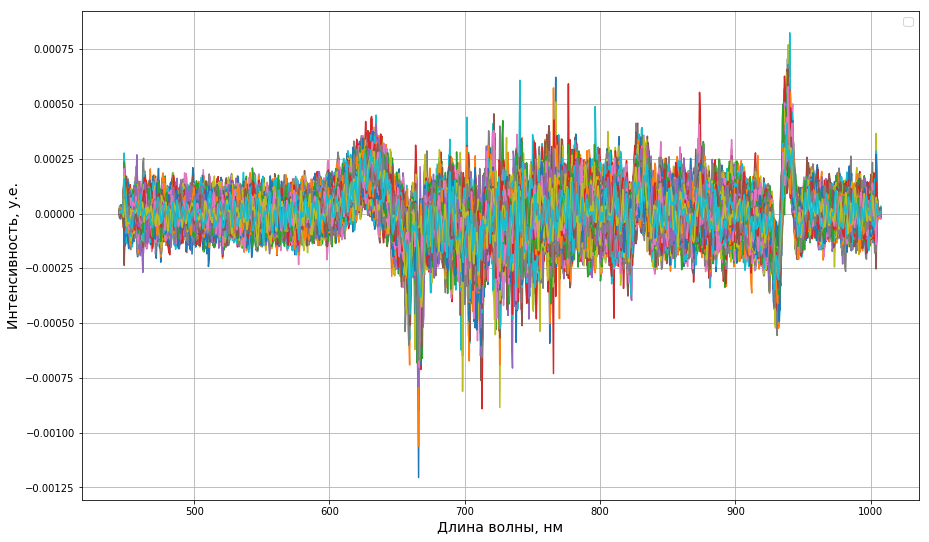

In [31]:
plt.figure(figsize=(15,9))
plt.grid(which=u'both')
for i in range(partial_2_Data.shape[0]):
    plt.plot(chnl_to_nm , partial_2_Data.iloc[i,:].values)
# plt.xlim(chnl_to_nm[0], chnl_to_nm[-1])
# plt.ylim(0)
plt.xlabel(u'Длина волны, нм', fontsize=14)
plt.ylabel(u'Интенсивность, у.е.', fontsize=14)
plt.legend(fontsize=12)
plt.show()

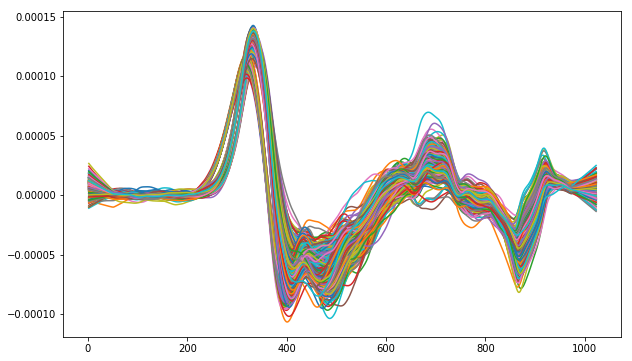

In [30]:
data_lowess_1 = list()
plt.figure(figsize=(10,6))
for i in range(partial_2_Data.shape[0]) :
    x = range(partial_2_Data.shape[1])
    y = partial_2_Data.iloc[i,:].values
    lowess = sm.nonparametric.lowess(y, x, frac=0.1)
    plt.plot(lowess[:,0], lowess[:,1])
    data_lowess_1.append(lowess[:,1])

lowess_SecondPartial_Data = pd.DataFrame(np.array(data_lowess_1))